In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sn
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.signal import hilbert

import json 
import pandas as pd
import numpy as np
import os
import glob

from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed


### *variables*

In [41]:
labels = []
derived_samples_list = []
file_names = []
sigmf_meta_files = []
feature_names = [
    "num_iq_samples",
    "amp_mean",
    "amp_std",
    "amp_skew",
    "amp_kurtosis",
    "amp_max",
    "amp_min",
    # "amp_25perc",
    # "amp_50perc",
    # "amp_75perc",
    "psd_mean",
    "psd_std",
    "psd_max",
    "psd_min",
    "spectral_centroid",
    "spectral_bandwidth",
    "spectral_flatness",
    "env_mean",
    "env_std",
    "freq_std"
]
num_features = len(feature_names)


data_dir = '/Volumes/DRIVE 128GB/iqSamples_Ruko_F11_Pro.csv'
drone_csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(drone_csv_files)

chunk_size = 10_000 # how many rows to hold in memory at a time
every_n_rows = 1000

# Example: sample windows with 50% overlap
# window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 2048 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 4096 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 8192 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 16_384 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 32_768 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)

# step = 8192
# step = 4096
# step = 2048
# step = 1024
step = 512

skipSVC = False
skipRF = True

[]


### *functions*

In [42]:
# other 
def getLabelFromFilename(filename): 
    filename = filename.lower()
    if "phantom" in filename: return "Phantom"
    elif "ruko_f11_pro" in filename: return "Ruko_F11_Pro"
    elif "ruko_f11_base" in filename: return "Ruko_F11_base"
    elif "mavic_air_2_" in filename: return "Mavic_Air_2"
    elif "mavic_air_2s" in filename: return "Mavic_Air_2S"
    elif "deerc" in filename: return "DeerC_DE2"
    elif "mini_se" in filename: return "Mini_SE"
    elif "holystone_hs100" in filename: return "Holystone_HS100"
    elif "none" in filename: return "None"
    else: return "unkown_label"



def load_iq(f, chunk_size, every_n_rows):
    # The chunking in this algo is so that we can read in large files (156M lines or more). 
    # In order to reduce compution time, we skip n number of rows. 
    result = pd.DataFrame()

    for chunk in pd.read_csv(f, chunksize=chunk_size):
        result = pd.concat([result, chunk.iloc[::every_n_rows, :]], ignore_index=True)

    # print("THE DF:\n", result)
    result = result[['i', 'q']].to_numpy()
    return result



# metric's functions 
def checkForFilename(base_name): 
    ext = ".txt"
    i = 1
    filename = f"{base_name}-{i}{ext}"
    while os.path.exists(filename):
        filename = f"{base_name}-{i}{ext}"
        i += 1
    return filename



def saveMetricsToFile(base_name, perc_accuracy, model): 
    filename = checkForFilename(base_name)
    with open(filename, "w") as f:
        f.write(f"Model: {model}\n")
        f.write(f"Accuracy: {perc_accuracy:.2f}%\n\n")
        f.write("\n")
        f.write(f"Number of samples: {len(labels)}\n")
        f.write("Count\tLabel\n")
        counts = Counter(labels)
        for item, count in counts.items():
            f.write(f"{count}\t{item}\n")
        f.write("\n")
        f.write("Classification Report:\n")
        f.write(f"{cr}\n\n")
        f.write("Confusion Matrix:\n")
        
        f.write(f"{cm}\n")





In [43]:
# for numpy conversion 

def extractStatFeatures(iq_window, num_iq_samples): 
    """
    This exracts the statistical features from an iq_window number of IQ samples. 
    This creates what we're calling a "derived" feature. 
    """
    f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
    # Spectral centroid / bandwidth / flatness:
    spectral_centroid = np.sum(f*Pxx)/np.sum(Pxx)
    spectral_bandwidth = np.sqrt(np.sum(Pxx*(f-spectral_centroid)**2)/np.sum(Pxx))
    spectral_flatness = np.exp(np.mean(np.log(Pxx+1e-12)))/np.mean(Pxx+1e-12)
    # Envelope statistics: use Hilbert transform to get instantaneous amplitude
    envelope = np.abs(hilbert(iq_window))
    env_mean = np.mean(envelope)
    env_std  = np.std(envelope)
    # Instantaneous frequency variance (phase derivative)
    phase = np.angle(iq_window)
    inst_freq = np.diff(phase)
    freq_std = np.std(inst_freq)

    sample = [
        int(num_iq_samples),
        np.mean(np.abs(iq_window)),        # mean amplitude
        np.std(np.abs(iq_window)),         # amplitude std
        skew(np.abs(iq_window)),           # skewness
        kurtosis(np.abs(iq_window)),       # kurtosis
        np.max(np.abs(iq_window)),         # max
        np.min(np.abs(iq_window)),         # min
        # np.percentile(np.abs(iq_window),25),
        # np.percentile(np.abs(iq_window),50),
        # np.percentile(np.abs(iq_window),75),
        np.mean(Pxx), np.std(Pxx), np.max(Pxx), np.min(Pxx),      # PSD stats
        spectral_centroid, # spectral
        spectral_bandwidth, # spectral
        spectral_flatness, # spectral
        env_mean, # envelope / freq
        env_std, # envelope / freq
        freq_std # envelope / freq
    ]
    
    return np.array(sample)




def binaryIQToNumpy(meta_file): 
    data_file = meta_file.replace("meta", "data")
    label = getLabelFromFilename(meta_file)

    print(f"Label: {label}")
    print(f"Converting: \n{meta_file.replace(".sigmf-meta", "")}")

    try:
        with open(meta_file, 'r') as f:
            meta = json.load(f)
            sigmf_meta_files.append(meta)
    except json.JSONDecodeError:
        print(f"Error: {json.JSONDecodeError}")
        return

    dtype_map = {
        "ri8_le":  np.int8,
        "ri16_le": np.int16,
        "ri32_le": np.int32,
        "rf32_le": np.float32,
        "cf32_le": np.complex64,
        "ci8_le":  np.int8,
        "ci16_le": np.int16,
        "ci32_le": np.int32,
    }
    dtype = dtype_map.get(meta["global"]["core:datatype"], np.int16)

    iq = np.fromfile(data_file, dtype=dtype)

    print(f"Converted {(len(iq) // 2):,} samples to numpy array")
    print(f"After conversion, one IQ sample: {iq[:2]}")
    
    return (iq)





def readInBinDirectoryWithAnnotations(dir): 
    binary_files = glob.glob(os.path.join(dir, "**", "*.sigmf-meta"), recursive=True)
    iq_files = []
    
    # first convert the files into a numpy array 
    for file in binary_files:
        print("--------------------------------------------")
        file_names.append(file)
        iq_files.append(binaryIQToNumpy(file))
    
    # Then create a numpy array of the statistical features from the files
    return grabStudioLabelsFromIQFiles(iq_files)





def grabStudioLabelsFromIQFiles(iq_files, max_workers=8):
    print("--------------------------------------------")
    print("\nNow extracting the features\n")

    segments = []

    # Collect all segments first
    for iq_file, meta_file in zip(iq_files, sigmf_meta_files):
        annotations = meta_file["annotations"]
        end = -1

        for ann in annotations:
            # Non-annotated region
            start = end + 1
            end = ann["core:sample_start"] * 2 - 1
            if end > start:
                labels.append("unknown")
                segments.append((iq_file[start:end].copy(), (end - start) // 2))
                # print(f"IQ Samples in seg: {(end - start) // 2}")


            # Annotated region
            start = ann["core:sample_start"] * 2
            end = start + ann["core:sample_count"] * 2
            labels.append(ann["core:label"])
            segments.append((iq_file[start:end].copy(), (end - start) // 2))
            # print(f"IQ Samples in seg: {(end - start) // 2}")

    print(f"Total segments to process: {len(segments)}")

    # Parallel feature extraction
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(extractStatFeatures, seg[0], seg[1]) for seg in segments]
        # for f in as_completed(futures):
        #     derived_samples_list.append(f.result())
        derived_samples_list = [f.result() for f in futures]  # preserves order


    return np.vstack(derived_samples_list)


## Loading Dataset

### *Reading in files*

In [44]:
data_dir = '/Volumes/DRIVE 128GB/'
# data_dir = '/home/uav-cyberlab-rfml/RFML/RFML-Code/RFML_Drone_Dataset_2025/old_drone_full_annotated_dataset'
derived_samples = readInBinDirectoryWithAnnotations(data_dir)

--------------------------------------------
Label: Mavic_Air_2
Converting: 
/Volumes/DRIVE 128GB/2025-10-15-20-59-04_mavic_air_2_5735MHz_chan_0
Converted 15,625,000 samples to numpy array
After conversion, one IQ sample: [-2357  8992]
--------------------------------------------
Label: DeerC_DE2
Converting: 
/Volumes/DRIVE 128GB/2025-10-16-23-27-01_deerc_de22_remote_500ms_2455MHz_chan_0
Converted 15,625,000 samples to numpy array
After conversion, one IQ sample: [ 0 -5]
--------------------------------------------
Label: Holystone_HS100
Converting: 
/Volumes/DRIVE 128GB/2025-10-16-22-16-49_holystone_hs100_500ms_5300MHz_chan_0
Converted 15,625,000 samples to numpy array
After conversion, one IQ sample: [-630 -945]
--------------------------------------------

Now extracting the features

Total segments to process: 620


/var/folders/3b/9d3900dj0b53yzgc017pbr480000gq/T/ipykernel_44997/1749012674.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 377, using nperseg = 377
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/var/folders/3b/9d3900dj0b53yzgc017pbr480000gq/T/ipykernel_44997/1749012674.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 24, using nperseg = 24
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD


### *displaying data*

In [51]:
print(f"Type of derived samples: {type(derived_samples)}")
print(f"Shape of derived samples: {derived_samples.shape}")
print()
print(f"Type of each sample: {type(derived_samples[0])}")
print(f"Shape of each sample: {derived_samples[0].shape}")
print()
print(f"Type of each feature: {type(derived_samples[0][0])}")
print()
print(f"Number of labels: {len(labels)}")
print()

print(f"Num IQ's\tLabel")
for i in range(20): 
    print(f"{int(derived_samples[i][0]):,}\t\t{labels[i]}")
print()
print(f"Two samples: \n{derived_samples[:2]}")
# print(f"{derived_samples[3][0]}\t\t{labels[3]}")

print()
print(f"Labels Found:")
print("Count\tLabel")
counts = Counter(labels)
for item, count in counts.items():
    print(f"{count}\t{item}")


Type of derived samples: <class 'numpy.ndarray'>
Shape of derived samples: (620, 17)

Type of each sample: <class 'numpy.ndarray'>
Shape of each sample: (17,)

Type of each feature: <class 'numpy.float64'>

Number of labels: 620

Num IQ's	Label
188		unknown
74,775		Ocusync_2.0_mavic_air_2_DL
29,027		unknown
95,971		Ocusync_2.0_mavic_air_2_DL
29,028		unknown
158,473		Ocusync_2.0_mavic_air_2_DL
60,277		unknown
64,722		Ocusync_2.0_mavic_air_2_DL
29,028		unknown
109,494		Ocusync_2.0_mavic_air_2_DL
12		unknown
48,962		Ocusync_2.0_mavic_air_2_DL
27,827		unknown
95,975		Ocusync_2.0_mavic_air_2_DL
60,873		unknown
127,224		Ocusync_2.0_mavic_air_2_DL
29,027		unknown
95,971		Ocusync_2.0_mavic_air_2_DL
29,629		unknown
127,221		Ocusync_2.0_mavic_air_2_DL

Two samples: 
[[1.88000000e+02 5.23859151e+03 3.95643686e+03 1.09517533e+00
  1.31624840e+00 2.01080000e+04 0.00000000e+00 8.43604800e+07
  2.13835072e+08 1.28168461e+09 1.39473114e+02 2.27541888e-01
  2.26366935e-01 3.76319024e-03 8.11362661e+03 

In [46]:
# Display the table 

if False: 
    print("  ", end="")
    print(" ".join(f"{x:>29}" for x in feature_names))

    np.set_printoptions(threshold=np.inf, linewidth=1000, suppress=True)
    print(np.array2string(
        derived_samples,
        formatter={'float_kind': '                     {:8.0f}'.format},
        max_line_width=12000  # increase line width
    ))

## Random Forest Classifer 

### *preprocessing*

In [47]:
X = derived_samples
y = np.array(labels)

print(f"Num samples: {X.shape}")
print(f"Num labels: {y.size}")
print(f"Number of features: {num_features}")

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Num samples: (620, 17)
Num labels: 620
Number of features: 17


### *Training, fitting & predicting*

I need to figure out how to use the random forest classifier for this. 

In [48]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### *Metrics*

In [49]:


accuracy = accuracy_score(y_test, y_pred)
perc_accuracy = accuracy * 100
print(f"Accuracy: {perc_accuracy:.2f}%")
print()
print(f"Number of samples: {len(labels)}")
print("Count\tLabel")
counts = Counter(labels)
for item, count in counts.items():
    print(f"{count}\t{item}")
print()

cr = classification_report(y_test, y_pred, target_names=le.classes_)
cm = confusion_matrix(y_test, y_pred)
print(cr)
print()
print(cm)
print()

saveMetricsToFile('svc_metrics', perc_accuracy, "Random Forest")

Accuracy: 98.39%

Number of samples: 620
Count	Label
301	unknown
107	Ocusync_2.0_mavic_air_2_DL
84	Ocusync_2.0_mavic_air_2_UL
52	DeerC_DE22_Uplink
76	HS100_Downlink

                            precision    recall  f1-score   support

         DeerC_DE22_Uplink       1.00      1.00      1.00        10
            HS100_Downlink       1.00      1.00      1.00        15
Ocusync_2.0_mavic_air_2_DL       0.96      1.00      0.98        22
Ocusync_2.0_mavic_air_2_UL       0.94      1.00      0.97        17
                   unknown       1.00      0.97      0.98        60

                  accuracy                           0.98       124
                 macro avg       0.98      0.99      0.99       124
              weighted avg       0.98      0.98      0.98       124


[[10  0  0  0  0]
 [ 0 15  0  0  0]
 [ 0  0 22  0  0]
 [ 0  0  0 17  0]
 [ 0  0  1  1 58]]



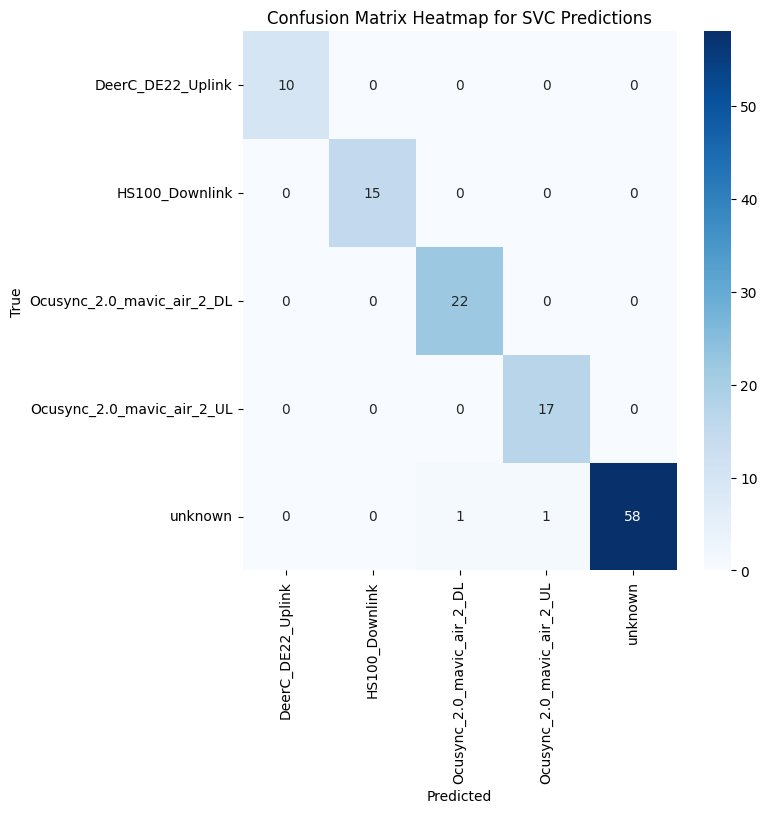

In [50]:
# Create a heatmap of the confusion matrix

plt.figure(figsize=(7, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap for SVC Predictions')

plt.show()
